# Run Tesseract on the DexRay algorithm

In [1]:
# Standard library imports
import argparse
import csv
import datetime
import os
import random as python_random
import sys
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tqdm import tqdm

# Optional import (commented)
# import tensorflow_addons as tfa

# Local imports
from tesseract import evaluation, metrics, mock, temporal, spatial


random_seed = 123456

2024-11-27 07:30:48.578704: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-27 07:30:48.714296: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-27 07:30:48.715877: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-27 07:30:52.017205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
APK_METADATA_PATH = "/scratch/users/mbenali/metadata.csv"

GOODWARE_PATH = "/scratch/users/mbenali/download_apk/100k_download/images/goodware"
MALWARE_PATH = "/scratch/users/mbenali/download_apk/100k_download/images/malware"

IMG_SIZE=128

### Time Plots

The first plot shows the distribution of all 10000 APKs.

Helper function `load_images()` to load and preprocess the grayscale images into a numpy array X

In [3]:
def extract_dates_from_csv():
    # List to hold the date objects
    date_list = []
    
    # Open and read the CSV file
    with open(APK_METADATA_PATH) as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip the header row
        for row in reader:
            # Convert the string from the 4th column to a datetime object
            try:
                date = datetime.strptime(row[3], '%Y-%m-%d %H:%M:%S')
                date_list.append(date)
            except ValueError:
                # Handle invalid date format if necessary
                pass
    
    # Convert the list of datetime objects to a numpy array
    return np.array(date_list)

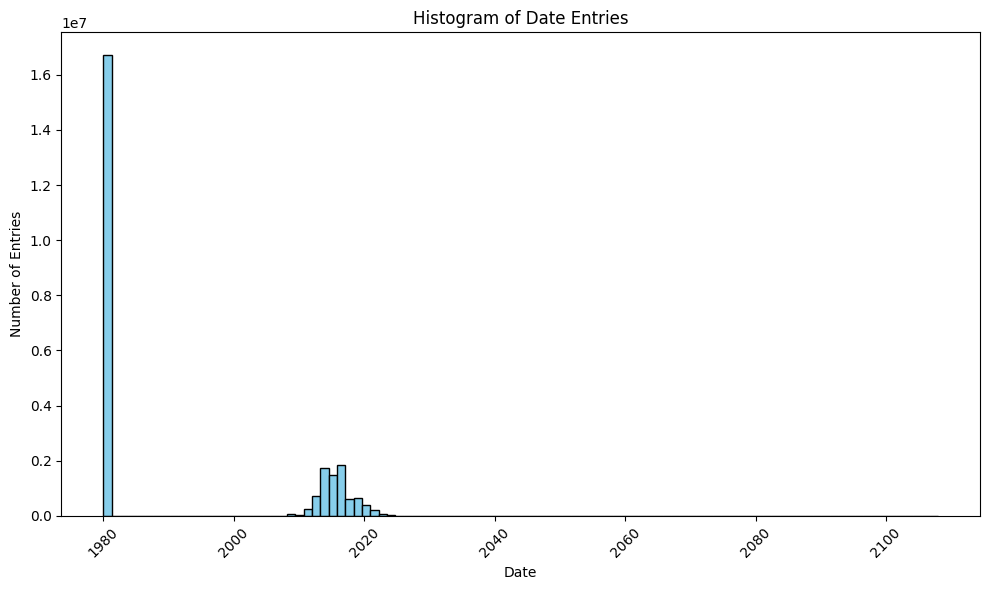

In [4]:
dates = extract_dates_from_csv()

plt.figure(figsize=(10, 6))
plt.hist(dates, bins=100, edgecolor='black', color='skyblue')
plt.xlabel('Date')
plt.ylabel('Number of Entries')
plt.title('Histogram of Date Entries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
# Define the start and end date for the x-axis
start_date = datetime(2008, 1, 1)
end_date = datetime(2025, 12, 31, 23, 59, 59)

# Generate the bin edges (start of each month between 2018 and 2019)
bins = []
current_date = start_date
while current_date <= end_date:
    bins.append(current_date)
    # Move to the start of the next month
    next_month = current_date.replace(day=28) + timedelta(days=4)  # Move to next month's first day
    current_date = next_month.replace(day=1)

# Plot the histogram with bins representing one month
plt.figure(figsize=(10, 6))
plt.hist(dates, bins=bins, edgecolor='black', color='skyblue')

# Set x-axis limits to the range from 2018-01-01 to 2019-12-31
plt.xlim(start_date, end_date)

# Label the axes and title
plt.xlabel('Date')
plt.ylabel('Number of Entries')
plt.title('Histogram of Date Entries (2018-2019)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Auto adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

NameError: name 'dates' is not defined

<Figure size 1000x600 with 0 Axes>

### Load X, y and temp

Here starts the new code getting X from the numpy files, y from the folder name and getting the corresponding date by searching the CSV.

In [5]:
def load_apk_metadata(file_path):
    """Loads the APK metadata from the CSV file into a dictionary for quick lookups."""
    metadata = {}
    with open(file_path, 'r') as csv_file:
        reader = csv.DictReader(csv_file, fieldnames=[
            'sha256', 'sha1', 'md5', 'date_time', 'number1',
            'package', 'number2', 'number3', 'dex_date', 'number4', 'source'
        ])
        csv_file.seek(0)  # Reset file pointer to the beginning
        for row in reader:
            metadata[row['sha256']] = row['dex_date']
    return metadata

def get_date_time_from_hash(search_hash, metadata):
    """
    Retrieves the `dex_date` for the given hash using preloaded metadata."""
    if search_hash in metadata:
        try:
            return datetime.strptime(metadata[search_hash], '%Y-%m-%d %H:%M:%S')
        except ValueError as e:
            print(f"Error parsing date for {search_hash}: {e}")
            return None
    return None

In [6]:
metadata = load_apk_metadata(APK_METADATA_PATH)

In [7]:
len(metadata)

24792509

In [8]:
NUMPY_FILES_DIR = "/scratch/users/mbenali/download_apk/npy2"
# Define timeframe of relevant apps 
YEAR_START = 2010
YEAR_END = 2022

def assemble_arrays():
    """Assembles numpy arrays from .npy files along with their labels and dates."""
    X = []
    y = []
    temp = []

    dirs = [NUMPY_FILES_DIR + '/malware', NUMPY_FILES_DIR + '/goodware']
    stop = 0

    for directory in dirs:
        if not os.path.exists(directory):
            continue
            
        for file in os.listdir(directory):
            if stop >= 10000:
                break
            stop += 1

            if not file.endswith('.npy'):
                continue

            # Obtain the date
            apk_date = get_date_time_from_hash(file[:-4], metadata)  # remove .npy

            # Do not include if outside of date range
            if apk_date is None or apk_date.year < YEAR_START or apk_date.year > YEAR_END:
                continue

            temp.append(apk_date)

            filepath = os.path.join(directory, file)
            array = np.load(filepath)
            X.append(array.flatten())  # Flattening ensures all arrays are rows

            # Obtain the label 
            y.append(0 if 'goodware' in directory else 1)

        print(f"Done with {directory}")

    return np.stack(X), np.array(y), np.array(temp)

In [9]:
X, y, temp = assemble_arrays()

Done with /scratch/users/mbenali/download_apk/npy2/malware
Done with /scratch/users/mbenali/download_apk/npy2/goodware


In [10]:
X[0]

array([0.59415936, 0.        , 0.5476491 , ..., 0.3806373 , 0.23897058,
       0.52254903], dtype=float32)

In [13]:
# Get all sorts of sanity checks
print(f"Shape of X: {X.shape}")
print(f"Contents of X[0]: {X[0]}")

print(f"\n# elements in y: {len(y)}")
print(f"# of unique elements in y (0, 1): {np.unique(y)}")
print(f"# of malware samples: {len(y[y == 1])}")
print(f"# of goodware samples: {len(y[y == 0])}")

print(f"\n# elements in temp: {len(temp)}")

Shape of X: (9031, 16384)
Contents of X[0]: [0.59415936 0.         0.5476491  ... 0.3806373  0.23897058 0.52254903]

# elements in y: 9031
# of unique elements in y (0, 1): [0 1]
# of malware samples: 1925
# of goodware samples: 7106

# elements in temp: 9031


### Create DexRay Model with Keras

In [14]:
model_architecture = Sequential()
model_architecture.add(
    Conv1D(
        filters=64,
        kernel_size=12,
        activation="relu",
        input_shape=(IMG_SIZE * IMG_SIZE, 1),
    )
)
model_architecture.add(MaxPooling1D(pool_size=12))
model_architecture.add(Conv1D(filters=128, kernel_size=12, activation="relu"))
model_architecture.add(MaxPooling1D(pool_size=12))
model_architecture.add(Flatten())
model_architecture.add(Dense(64, activation="sigmoid"))
model_architecture.add(Dense(1, activation="sigmoid"))

model = keras.models.clone_model(model_architecture)
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(),
)

In [91]:
# Define a custom fit function so that we can change the number of epochs.
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=50, restore_best_weights=True
)

def fit_with_epochs(X_train, y_train):
    model.fit(
        X_train,
        y_train,
        shuffle=True,
        epochs=200, # TODO: hardcoded for now because just wanna try
        callbacks=[es_callback],
        verbose=2,
    )

def predict_keras(X_test):
    probabilities = model.predict(X_test, verbose=0)
    return (probabilities > 0.5).astype(int).flatten()  # Convert to 1D array of labels

### Tesseract

Split the data with Tesseract's `time_aware_train_test_split`

In [92]:
splits = temporal.time_aware_train_test_split(
    X, y, temp, train_size=96, test_size=2, granularity='month'
)
X_train, X_test, y_train, y_test, t_train, t_test = splits

print(f"X_train: {X_train.shape}") # Sanity Check
print(f"X_test: {len(X_test)}") # Sanity Check

X_train: (6103, 16384)
X_test: 21


In [93]:
# Downsample so that there's the requested percentage of malware in the training data
downsample = False
if downsample:    
    train_idxs = spatial.downsample_to_rate(y_train, 0.70)

    X_train = X_train[train_idxs]
    y_train = y_train[train_idxs]
    temp_train = t_train[train_idxs]

    print(f"# of malware samples: {len(y_train[y_train == 1])}")
    print(f"# of goodware samples: {len(y_train[y_train == 0])}")

In [94]:
results = evaluation.fit_predict_update(model, *splits, fit_function=fit_with_epochs, predict_function=predict_keras)

Epoch 1/200
191/191 - 26s - loss: 3.4143e-04 - 26s/epoch - 136ms/step
Epoch 2/200
191/191 - 26s - loss: 3.3132e-04 - 26s/epoch - 135ms/step
Epoch 3/200
191/191 - 26s - loss: 3.4456e-04 - 26s/epoch - 134ms/step
Epoch 4/200
191/191 - 26s - loss: 3.4413e-04 - 26s/epoch - 134ms/step
Epoch 5/200
191/191 - 26s - loss: 3.4289e-04 - 26s/epoch - 134ms/step
Epoch 6/200
191/191 - 26s - loss: 3.4335e-04 - 26s/epoch - 134ms/step
Epoch 7/200
191/191 - 26s - loss: 3.4190e-04 - 26s/epoch - 134ms/step
Epoch 8/200
191/191 - 26s - loss: 3.4267e-04 - 26s/epoch - 134ms/step
Epoch 9/200
191/191 - 26s - loss: 3.3901e-04 - 26s/epoch - 135ms/step
Epoch 10/200
191/191 - 26s - loss: 3.4362e-04 - 26s/epoch - 135ms/step
Epoch 11/200
191/191 - 27s - loss: 3.3441e-04 - 27s/epoch - 140ms/step
Epoch 12/200
191/191 - 26s - loss: 3.4848e-04 - 26s/epoch - 134ms/step
Epoch 13/200
191/191 - 26s - loss: 3.4064e-04 - 26s/epoch - 135ms/step
Epoch 14/200
191/191 - 26s - loss: 3.4829e-04 - 26s/epoch - 135ms/step
Epoch 15/200
19

In [98]:
# Save the model
model.save("/scratch/users/mbenali/tesseract-ml-release/model-200-epochs")

INFO:tensorflow:Assets written to: /scratch/users/mbenali/tesseract-ml-release/model-200-epochs/assets


INFO:tensorflow:Assets written to: /scratch/users/mbenali/tesseract-ml-release/model-200-epochs/assets


In [100]:
metrics.print_metrics(results)

------------+---------------------------------------------------------------------------------------------------------------------------------------------------
Test period |     1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20     21   
------------+---------------------------------------------------------------------------------------------------------------------------------------------------
Actual pos  |     38     74     16     36     62     21     18     14     13     13     26     23     15     38    103     75     15      9     54     43      6
Actual neg  |    115    133     33     46     98    245     96     55     60     41     46     63     61    220    406    141     95     42     43    161     16
Total       |    153    207     49     82    160    266    114     69     73     54     72     86     76    258    509    216    110     51     97    204     22
------------+-------------------

F1 AUT: 0.5261614022537773
Recall AUT: 0.5965661305667187
Precision AUT: 0.4921489213682021


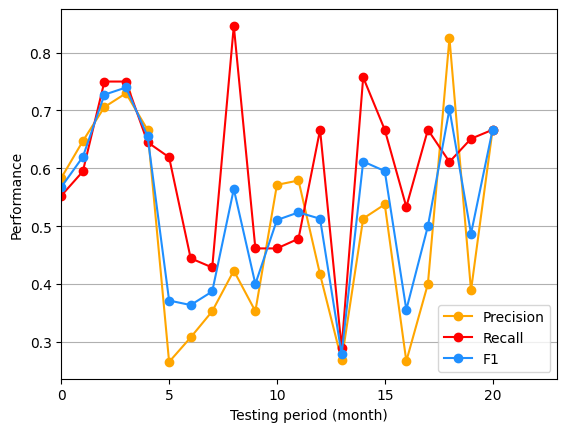

In [101]:
print(f"F1 AUT: {metrics.aut(results, 'f1')}")
print(f"Recall AUT: {metrics.aut(results, 'recall')}")
print(f"Precision AUT: {metrics.aut(results, 'precision')}")
#%%
from pylab import *

pendleblue='#1f8fff'
pendleyellow='#ffa600'

'#FF9999', '#FFDD99', '#AAEEEE'
plot(results['precision'], marker='o', color=pendleyellow)
plot(results['recall'], marker='o', color='red')
plot(results['f1'], marker='o', color=pendleblue)
legend(['Precision', 'Recall', 'F1'])
xlim([0,23])
xlabel('Testing period (month)')
ylabel('Performance')
grid(axis = 'y')

Conclusion: We might be training and predicting over too many months/years, which causes the metrics to jump like this? 